# Smoothing

# 1. Initialisation

## Import libraries and scripts

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import AutoMinorLocator

import numpy as np
from time import time
from scipy import ndimage

import importlib
import scripts
importlib.reload(scripts)

> DEBUG: all scripts have been reloaded
> DEBUG: all scripts have been reloaded


<module 'scripts' from '/home/yago/public/git/paranoya/image-processing/scripts/__init__.py'>

## Read data

In [2]:
importlib.reload(scripts.read_data)
object_name, data, wcs = scripts.read_data.run(22, (0, 0, 1))

Read dataset 22: "NGC2420" (400, 400) (0.108 s)


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


# 2. Noise reduction

## Smoothing

In [3]:
n_smooth = 10
kernel_sizes = np.logspace(0, np.log10(data.size)/len(data.shape), n_smooth)
print(f'smoothing radius: {kernel_sizes}')

smoothing radius: [  1.           1.94588772   3.78647901   7.368063    14.33742329
  27.89901588  54.28835233 105.63903801 205.56170656 400.        ]


In [4]:
smooth_data = np.empty((n_smooth,)+data.shape)
for i, radius in enumerate(kernel_sizes):
    smooth_data[i] = ndimage.gaussian_filter(np.where(np.isfinite(data), data, 0), radius)

## Background, noise, and significance estimates

In [5]:
'''
relative_tolerance = 1e-3
absolute_tolerance = 1e-30
def convergence(old, new):
    #print(old, new, (old - new)**2 <= relative_tolerance**2*(old**2 + new**2), ((old - new)**2 <= absolute_tolerance**2))
    return ((old - new)**2 <= relative_tolerance**2*(old**2 + new**2)) or ((old - new)**2 <= absolute_tolerance**2)


def find_background(x):
    old_mu = np.nanmean(x)
    old_var = np.nanvar(x)
    old_N0 = x.size
    p16, p50, p84 = np.nanpercentile(x.flat, [16, 50, 84])
    mu_w = p50
    var_w = min(p50-p16, p84-p50)**2
    N0 = x.size // 2

    while not (convergence(mu_w, old_mu)
               & convergence(var_w, old_var)
               & convergence(N0, old_N0)):
        weight = np.exp(-.5 * (x.flat-mu_w)**2 / var_w)
        total_weight = np.nansum(weight)
        mu = np.nansum(weight * x.flat) / total_weight
        var =  np.nansum(weight * (x.flat-mu)**2) / total_weight
        var0 = 1 / (1/var - 1/var_w)
        mu0 = var0 * (mu/var - mu_w/var_w)
        
        old_mu = mu_w
        old_var = var_w
        old_N0 = N0
        mu_w = mu0
        var_w = max(var0, absolute_tolerance)  # to prevent underflow
        N0 = np.count_nonzero(x < mu0)
        #print(mu0, var0, N0)

    print(f'{N0} values ({100*N0/x.size:.1f}%) below background = {mu0:.3e} +- {np.sqrt(var0):.3e} (median = {p50:.3e})')
    return mu0, np.sqrt(var0)


smooth_significance = np.zeros_like(smooth_data)
for i, radius in enumerate(kernel_sizes):
    bg, sigma_bg = find_background(smooth_data[i])
    smooth_significance[i] = (smooth_data[i] - bg) / sigma_bg

bg, sigma_bg = find_background(data)
significance = (data - bg) / sigma_bg
'''


"\nrelative_tolerance = 1e-3\nabsolute_tolerance = 1e-30\ndef convergence(old, new):\n    #print(old, new, (old - new)**2 <= relative_tolerance**2*(old**2 + new**2), ((old - new)**2 <= absolute_tolerance**2))\n    return ((old - new)**2 <= relative_tolerance**2*(old**2 + new**2)) or ((old - new)**2 <= absolute_tolerance**2)\n\n\ndef find_background(x):\n    old_mu = np.nanmean(x)\n    old_var = np.nanvar(x)\n    old_N0 = x.size\n    p16, p50, p84 = np.nanpercentile(x.flat, [16, 50, 84])\n    mu_w = p50\n    var_w = min(p50-p16, p84-p50)**2\n    N0 = x.size // 2\n\n    while not (convergence(mu_w, old_mu)\n               & convergence(var_w, old_var)\n               & convergence(N0, old_N0)):\n        weight = np.exp(-.5 * (x.flat-mu_w)**2 / var_w)\n        total_weight = np.nansum(weight)\n        mu = np.nansum(weight * x.flat) / total_weight\n        var =  np.nansum(weight * (x.flat-mu)**2) / total_weight\n        var0 = 1 / (1/var - 1/var_w)\n        mu0 = var0 * (mu/var - mu_w/va

In [6]:
def find_background(x, half_nbins=None):
    n_valid = np.count_nonzero(np.isfinite(x))
    if half_nbins is None:
        half_nbins = min(int(np.sqrt(n_valid)), 100)
    nbins = 2*half_nbins + 1  # make sure n_bins is odd

    percentile = np.linspace(100/n_valid, 100*(1-1/n_valid), nbins)
    percentile_value = np.nanpercentile(x, percentile)
    median = percentile_value[half_nbins]
    rho = 1 / (percentile_value[1:] - percentile_value[:-1])
    x_rho = (percentile_value[1:] + percentile_value[:-1]) / 2

    '''
    w = np.interp(x, x_rho, rho)
    total_weight = np.nansum(w)
    bg = np.nansum(w*x) / total_weight
    sigma_bg = np.sqrt(np.nansum(w*(x-bg)**2) / total_weight)
    '''
    w = rho**2
    total_weight = np.nansum(w)
    bg = np.nansum(w*x_rho) / total_weight
    sigma_bg = np.sqrt(np.nansum(w*(x_rho-bg)**2) / total_weight)

    return bg, sigma_bg


smooth_significance = np.zeros_like(smooth_data)
for i, radius in enumerate(kernel_sizes):
    bg, sigma_bg = find_background(smooth_data[i])
    smooth_significance[i] = (smooth_data[i] - bg).clip(min=0) / sigma_bg

bg, sigma_bg = find_background(data)
significance = (data - bg).clip(min=0) / sigma_bg


In [7]:
'''
mean_significance = significance.copy()
total_weight = np.zeros_like(mean_significance)


smooth_weight = np.zeros_like(smooth_data)  # To be removed

for i, radius in enumerate(kernel_sizes):
    weight = 2*data*smooth_data[i]/(data**2 + smooth_data[i]**2)
    weight[~np.isfinite(weight)] = 0
    weight = weight**2
    weight = ndimage.gaussian_filter(weight, radius)
    r0 = 10
    weight = radius/r0 * np.exp(-radius/r0)
    smooth_weight[i] = weight  # To be removed
    total_weight += weight
    mean_significance += weight * smooth_significance[i]
mean_significance /= total_weight
'''


'\nmean_significance = significance.copy()\ntotal_weight = np.zeros_like(mean_significance)\n\n\nsmooth_weight = np.zeros_like(smooth_data)  # To be removed\n\nfor i, radius in enumerate(kernel_sizes):\n    weight = 2*data*smooth_data[i]/(data**2 + smooth_data[i]**2)\n    weight[~np.isfinite(weight)] = 0\n    weight = weight**2\n    weight = ndimage.gaussian_filter(weight, radius)\n    r0 = 10\n    weight = radius/r0 * np.exp(-radius/r0)\n    smooth_weight[i] = weight  # To be removed\n    total_weight += weight\n    mean_significance += weight * smooth_significance[i]\nmean_significance /= total_weight\n'

In [8]:
'''
def find_excess(data, half_nbins=None):
    n_valid = np.count_nonzero(np.isfinite(data))
    if half_nbins is None:
        half_nbins = min(int(np.sqrt(n_valid)), 100)
    nbins = 2*half_nbins + 1  # make sure n_bins is odd

    percentile = np.linspace(100/n_valid, 100*(1-1/n_valid), nbins)
    percentile_value = np.nanpercentile(data, percentile)
    median = percentile_value[half_nbins]

    minimum_distance = np.fmin(median-percentile_value[:half_nbins], percentile_value[-1:half_nbins:-1]-median)
    symmetrised_value = np.concatenate([median-minimum_distance, [median], median+minimum_distance[::-1]])

    excess = (percentile_value-symmetrised_value)
    #norm = (median-symmetrised_value[0])
    norm = np.std(symmetrised_value)
    excess /= norm
    
    return np.interp(data, percentile_value, excess)


smooth_significance = np.zeros_like(smooth_data)
for i, radius in enumerate(kernel_sizes):
    smooth_significance[i] = find_excess(smooth_data[i])

significance = find_excess(data)
'''


'\ndef find_excess(data, half_nbins=None):\n    n_valid = np.count_nonzero(np.isfinite(data))\n    if half_nbins is None:\n        half_nbins = min(int(np.sqrt(n_valid)), 100)\n    nbins = 2*half_nbins + 1  # make sure n_bins is odd\n\n    percentile = np.linspace(100/n_valid, 100*(1-1/n_valid), nbins)\n    percentile_value = np.nanpercentile(data, percentile)\n    median = percentile_value[half_nbins]\n\n    minimum_distance = np.fmin(median-percentile_value[:half_nbins], percentile_value[-1:half_nbins:-1]-median)\n    symmetrised_value = np.concatenate([median-minimum_distance, [median], median+minimum_distance[::-1]])\n\n    excess = (percentile_value-symmetrised_value)\n    #norm = (median-symmetrised_value[0])\n    norm = np.std(symmetrised_value)\n    excess /= norm\n    \n    return np.interp(data, percentile_value, excess)\n\n\nsmooth_significance = np.zeros_like(smooth_data)\nfor i, radius in enumerate(kernel_sizes):\n    smooth_significance[i] = find_excess(smooth_data[i])\n\

In [9]:
'''
total_weight = find_excess(mean_significance)
mean_significance = significance * total_weight

smooth_weight = np.zeros_like(smooth_data)  # To be removed
for i, radius in enumerate(kernel_sizes):
    weight = 2*data*smooth_data[i]/(data**2 + smooth_data[i]**2)
    weight[~np.isfinite(weight)] = 0
    weight = ndimage.gaussian_filter(weight, radius/2)
    #weight = 1
    smooth_weight[i] = weight  # To be removed
    total_weight += weight
    mean_significance += weight * smooth_significance[i]
    #mean_significance += weight * smooth_significance[i]**3
    #mean_significance += weight * smooth_data[i]
#mean_significance = np.cbrt(mean_significance/total_weight)
mean_significance /= total_weight
'''


'\ntotal_weight = find_excess(mean_significance)\nmean_significance = significance * total_weight\n\nsmooth_weight = np.zeros_like(smooth_data)  # To be removed\nfor i, radius in enumerate(kernel_sizes):\n    weight = 2*data*smooth_data[i]/(data**2 + smooth_data[i]**2)\n    weight[~np.isfinite(weight)] = 0\n    weight = ndimage.gaussian_filter(weight, radius/2)\n    #weight = 1\n    smooth_weight[i] = weight  # To be removed\n    total_weight += weight\n    mean_significance += weight * smooth_significance[i]\n    #mean_significance += weight * smooth_significance[i]**3\n    #mean_significance += weight * smooth_data[i]\n#mean_significance = np.cbrt(mean_significance/total_weight)\nmean_significance /= total_weight\n'

In [10]:
#total_weight = 1-np.exp(-find_excess(significance).clip(min=0))
total_weight = 1
#total_weight = np.nanmean(significance[significance > 0]) / np.nanmean(-significance[significance < 0])
print(total_weight)
mean_significance = significance * total_weight

#smooth_weight = np.zeros_like(smooth_data)  # To be removed
for i, radius in enumerate(kernel_sizes):
    #weight = 1-np.exp(-find_excess(smooth_significance[i]).clip(min=0))
    #weight = radius*np.exp(-radius)
    weight = np.nanstd(smooth_significance[i]) / np.nanstd(significance)
    #weight = np.nanmean(smooth_significance[i][smooth_significance[i] > 0]) / np.nanmean(-smooth_significance[i][smooth_significance[i] < 0])
    #weight = 1
    #weight = 1
    #smooth_weight[i] = weight  # To be removed
    print(f'{radius:7.2f}, {weight:7.2f}')
    total_weight += weight
    mean_significance += weight * smooth_significance[i]
    #mean_significance += weight * smooth_significance[i]**3
    #mean_significance += weight * smooth_data[i]
#mean_significance = np.cbrt(mean_significance/total_weight)
mean_significance /= total_weight

1
   1.00,    0.98
   1.95,    0.83
   3.79,    0.60
   7.37,    0.41
  14.34,    0.32
  27.90,    0.35
  54.29,    0.49
 105.64,    0.48
 205.56,    0.23
 400.00,    0.20


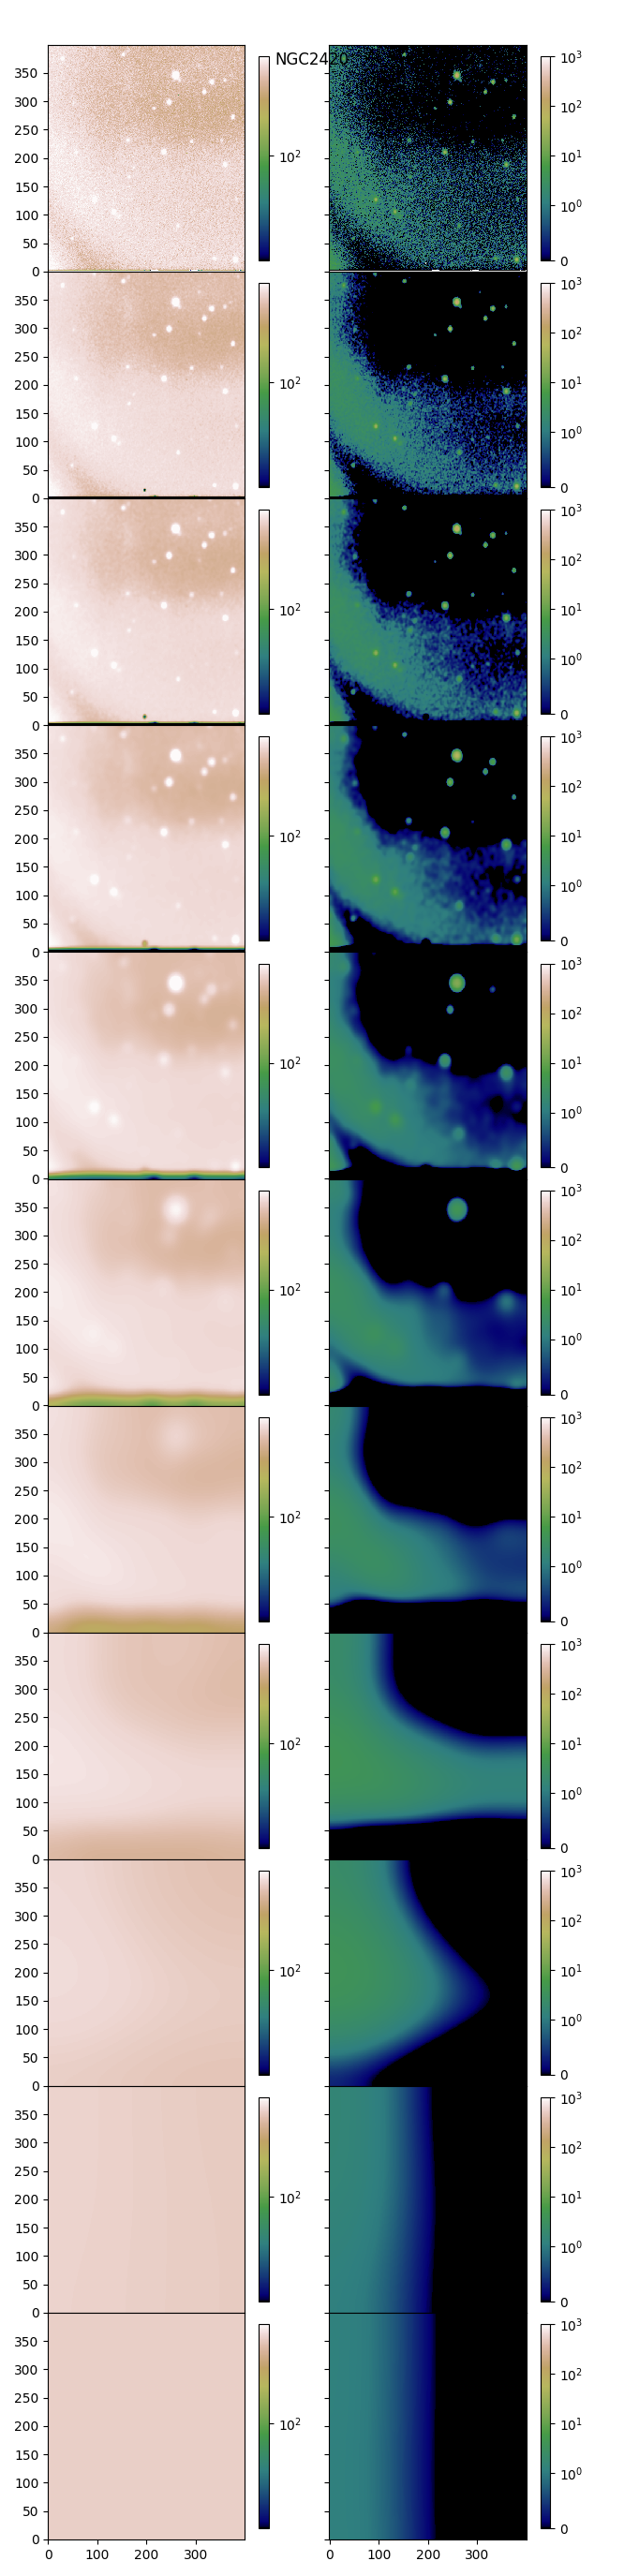

In [11]:
fig_name = 'visual_inspection'
plt.close(fig_name)

nrows = n_smooth+1
ncols = 2
panel_size = 2.5
cbar_fraction = .25

fig = plt.figure(fig_name, figsize=(ncols*panel_size/(1-cbar_fraction), nrows*panel_size))
axes = fig.subplots(nrows=nrows, ncols=ncols, squeeze=False,
                    sharex=True, sharey=True,
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(object_name)


def show_data(data, ax, cmap, norm):
    n_dim = len(data.shape)
    if n_dim == 2:
        intensity = data
    elif n_dim ==3:
        intensity = np.nanmean(data, axis=0)
        intensity = np.cbrt(np.nanmean(data**3, axis=0))
    else:
        print(f'ERROR: data has {n_dim} dimensions: {data.shape}')
        return
    
    im = ax.imshow(intensity,
                   interpolation='nearest', origin='lower',
                   cmap=cmap,
                   norm=norm,
                  )
    ax.set_aspect('auto')
    cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9, fraction=cbar_fraction)
    cb.ax.xaxis.label.set_size('small')


norm = colors.SymLogNorm(vmax=np.nanpercentile(data, 99), linthresh=np.nanmedian(data))
show_data(data, axes[0, 0], "gist_earth", norm)
for i in range(n_smooth):
    show_data(smooth_data[i], axes[i+1, 0], "gist_earth", norm)


norm = colors.SymLogNorm(vmin=0, vmax=1e3, linthresh=1)
#norm = colors.LogNorm()
#norm = colors.Normalize(vmin=-1, vmax=1)
show_data(significance, axes[0, 1], "gist_earth", norm)
for i in range(n_smooth):
    show_data(smooth_significance[i], axes[i+1, 1], "gist_earth", norm)

    
#pmin, p50, pmax = np.nanpercentile(intensity, [16, 50, 99])
#norm = colors.SymLogNorm(vmin=pmin, linthresh=2*p50-pmin, vmax=pmax)
#show_data(mean_significance, axes[0, 2], "gist_earth", norm)
#norm = colors.Normalize(vmin=0, vmax=1)
#for i in range(n_smooth):
#    show_data(smooth_weight[i], axes[i+1, 2], "rainbow", norm)

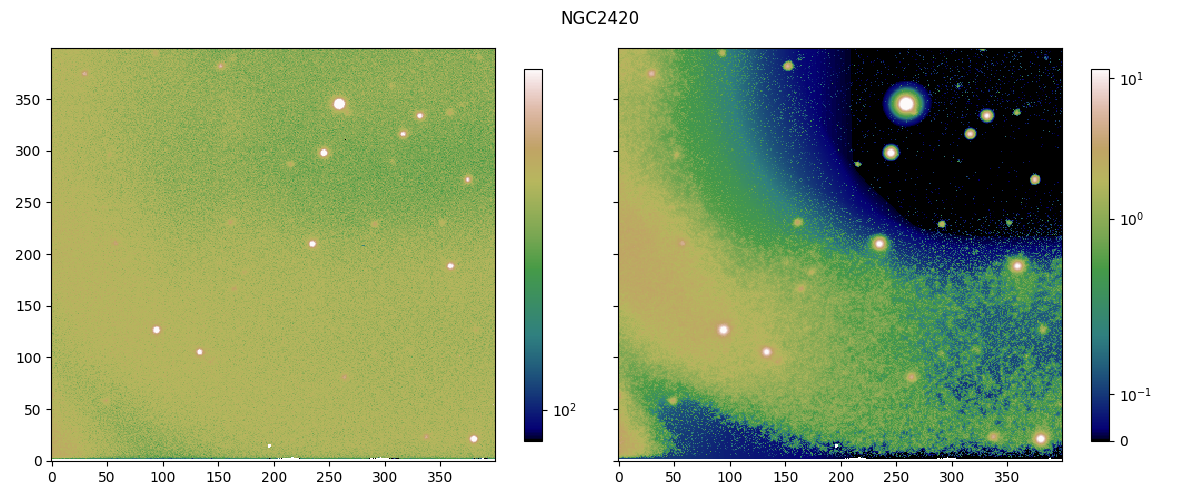

In [12]:
fig_name = 'mean_significance'
plt.close(fig_name)

ncols = 2
nrows = 1
panel_size = 5
cbar_size = 1
cbar_fraction = cbar_size/(panel_size+cbar_size)

fig = plt.figure(fig_name, figsize=(ncols*(panel_size+cbar_size), nrows*panel_size))
axes = fig.subplots(nrows=nrows, ncols=ncols, squeeze=False,
                    sharex=True, sharey=True,
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(object_name)


def show_data(data, ax, cmap, norm, levels):
    n_dim = len(data.shape)
    if n_dim == 2:
        intensity = data
    elif n_dim ==3:
        #intensity = np.nanmean(data, axis=0)
        #intensity = np.nanmax(data, axis=1)
        intensity = np.cbrt(np.nanmean((data-np.nanmean(data))**3, axis=0))
    else:
        print(f'ERROR: data has {n_dim} dimensions: {data.shape}')
        return
    
    im = ax.imshow(intensity,
                   interpolation='nearest', origin='lower',
                   cmap=cmap,
                   norm=norm,
                  )
    ax.set_aspect('auto')
#    bg, sigma_bg = find_background(intensity)
#    ax.contour(intensity, levels=bg+sigma_bg*np.array(levels), colors='black')
    cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9, fraction=cbar_fraction)
    cb.ax.xaxis.label.set_size('small')



p_min, p_lin, p_max = np.nanpercentile(data, [.01, 50, 99.9])
norm = colors.SymLogNorm(vmin=p_min, vmax=p_max, linthresh=p_lin)
show_data(data, axes[0, 0], "gist_earth", norm, [2, 3, 5, 10, 100])
#norm = colors.SymLogNorm(vmin=0, vmax=np.nanpercentile(mean_significance, 99.9), linthresh=np.nanmedian(mean_significance))
p_min, p_lin, p_max = np.nanpercentile(mean_significance, [.01, 50, 99.9])
norm = colors.SymLogNorm(vmin=p_min, vmax=p_max, linthresh=p_lin)
#norm = colors.Normalize(vmin=-.1, vmax=1)
show_data(mean_significance, axes[0, 1], "gist_earth", norm, [2, 3, 5, 10, 100])


## Sorting

In [13]:
importlib.reload(scripts.sort_data)
argsorted_data, n_valid = scripts.sort_data.run(mean_significance.ravel())

Sorted 159154 finite measurements in ascending order (0.0139 s)


In [14]:
argsorted_data.size, np.count_nonzero(mean_significance > 0)

(159154, 131080)

# 3. Source finding

## Hierarchical Overdensity Tree (HOT)

In [15]:
importlib.reload(scripts.HOT)
sorted_strides = np.hstack([np.sort(data.strides)//data.itemsize, data.size]) # DIRTY HACK when testig particles at the boundary
t0 = time()
label, catalog = scripts.HOT.run(data, argsorted_data, sorted_strides)
print(f'     {time()-t0:.3g} seconds')

HOT: 22645 overdensities found, 159154 "pixels" (99%), 1 independent regions
     4.5 seconds


In [16]:
parent = catalog[0]
area = catalog[1]
test_stat = catalog[2]
#max_test_stat = catalog[3]

In [42]:
#cut = 1 + np.mean(mean_significance)
#cut = 30
cut = np.nansum(data)/data.size

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


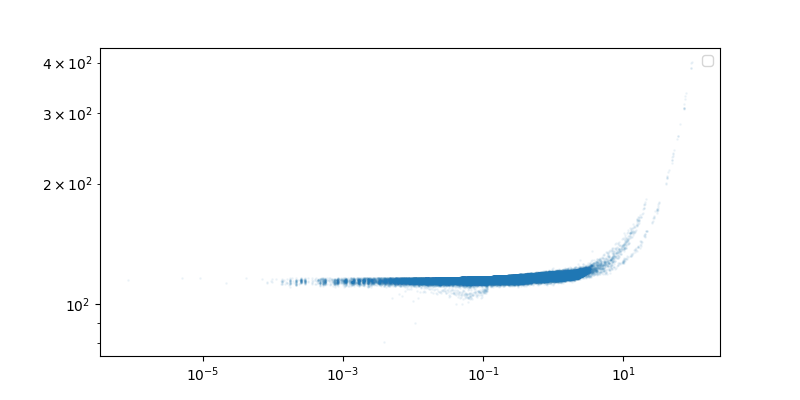

In [38]:
fig_name = 'test_test_stat'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(8, 4))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex=True, sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0})

ax = axes[0, 0]  # ----------------- new panel
'''
ax.scatter(area, test_stat, s=1, alpha=.1)
#ax.set_yscale('symlog')
ax.set_ylim(-100, 200)
#ax.set_xlim(-.1, 20)
ax.set_xscale('log')

n_sources = np.count_nonzero((test_stat > cut) & (area > cut))
ax.axhline(cut, c='k', ls='--', label=f'{np.count_nonzero(test_stat > cut)}')
ax.axvline(cut, c='k', ls=':', label=f'{n_sources}')
'''

ax.scatter(mean_significance.flat, data.flat, s=1, alpha=.05)
ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc='upper right')

In [83]:
def show_parents(labels, parents, ax):
    for obj in np.unique(labels):
        if area[obj] > 10:
            y_obj, x_obj = np.unravel_index(np.nanargmax(np.where(label == obj, data, -np.inf)), data.shape)
            y_par, x_par = np.unravel_index(np.nanargmax(np.where(label == parents[obj], data, -np.inf)), data.shape)
            #print(f'{obj}, {parents[obj]}, {x_obj, y_obj}')
            ax.plot([x_obj, x_par], [y_obj, y_par], 'k+-', alpha=.5)

def show_segmentation(intensity, labels):
    fig_name = 'segmentation'
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=(12, 8))
    
    axes = fig.subplots(nrows=2, ncols=2, squeeze=False,
                        sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

    ax = axes[0, 0]
    ax.set_title(object_name)
    im = ax.imshow(
        intensity,
        interpolation='nearest', origin='lower',
        #cmap='ocean',
        #cmap='nipy_spectral',
        #cmap='terrain',
        #cmap='magma',
        #cmap='gist_heat',
        cmap='gist_earth',
        #cmap='YlGn',
        norm=colors.SymLogNorm(linthresh=np.nanmedian(intensity)),
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)

    ax = axes[0, 1]
    ax.set_title('Significance')
    im = ax.imshow(
        mean_significance,
        interpolation='nearest', origin='lower',
        cmap='gist_earth',
        #vmax=1,
        norm=colors.SymLogNorm(linthresh=np.nanmedian(mean_significance)),
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)

    ax = axes[1, 0]
    ax.set_title(f'segmentation')
    im = ax.imshow(
        #labels == study_object,
        labels,
        interpolation='nearest', origin='lower',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)
    #show_parents(labels, parent, ax)

    ax = axes[1, 1]
    ax.set_title(f'Test statistic')
    im = ax.imshow(
        test_stat[labels], #*area[labels],
        #np.where(labels == 8448, intensity, 0),
        interpolation='nearest', origin='lower',
        #cmap='nipy_spectral_r',
        #cmap='inferno_r',
        cmap='hot', vmin=cut/2, vmax=cut,
        #cmap='seismic_r', norm=colors.LogNorm(vmin=.1*cut, vmax=10*cut),
        )
    cb = fig.colorbar(im, ax=ax)

    for ax in axes.flatten():
        ax.tick_params(which='both', direction='in')
        ax.grid(alpha=.5)
    fig.set_tight_layout(True)
    plt.show()

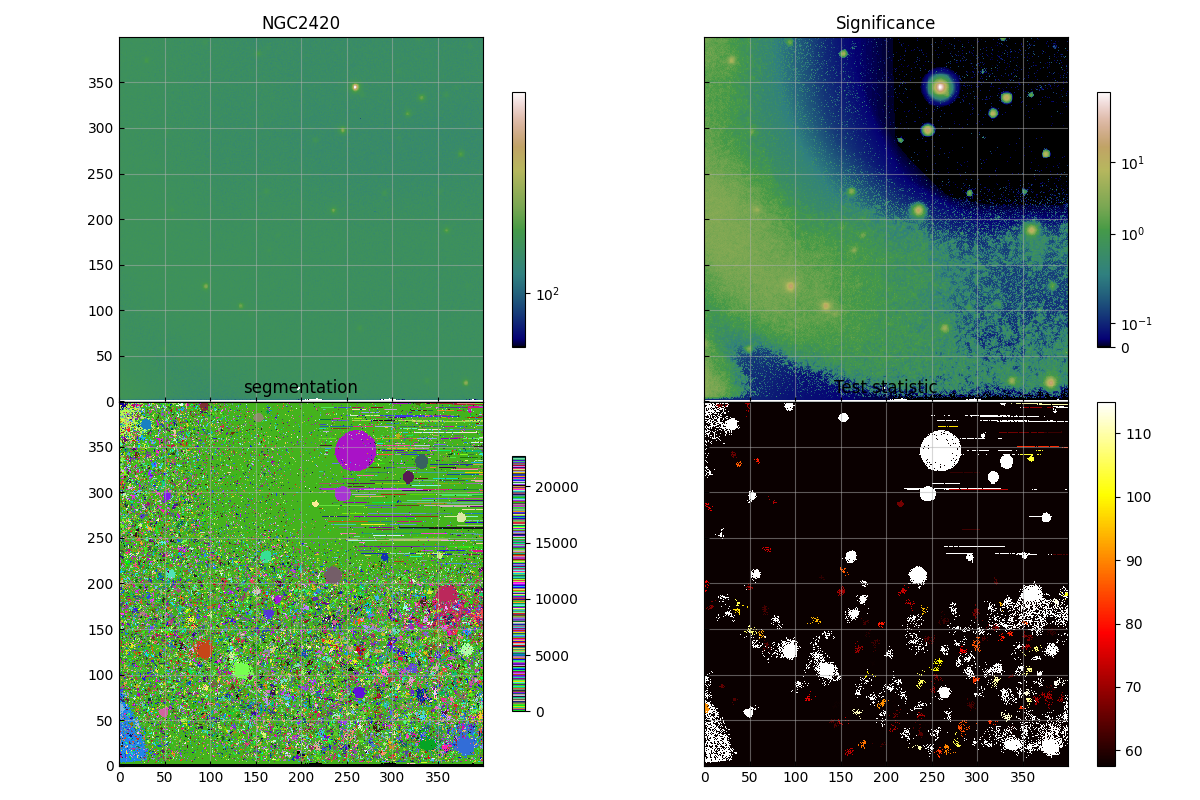

In [84]:
data_dimensionality = sorted_strides.size-1
n_sources = np.unique(label).size
my_cmap = np.vstack([(np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, np.ones(n_sources)]).T
my_cmap[0, :] = [0., 0., 0., 1.]
final_cmap = colors.ListedColormap(my_cmap)

if data_dimensionality == 2:
    show_segmentation(data, label)

elif data_dimensionality == 3:
    axis = 0
    intensity = np.nanmean(mean_significance, axis=axis)
    #intensity = np.nanmean(data**2, axis=1)
    #intensity = np.nanmax(data, axis=1)
    #intensity = np.cbrt(np.nanmean((mean_significance-np.nanmean(mean_significance))**3, axis=axis))
    pmin, p50, pmax = np.nanpercentile(intensity, [16, 50, 99])
    intensity_scale = colors.SymLogNorm(vmin=pmin, linthresh=2*p50-pmin, vmax=pmax)
    #intensity_scale = colors.Normalize(vmin=0, vmax=1)
    show_segmentation(intensity, np.nanmax(label, axis=axis), intensity_scale)


In [30]:
np.count_nonzero(label == 7838), area[7838], test_stat[7838]

(29, 68, 74.10372161865234)

In [82]:
x = data[label == 8448]
b = np.min(x)
np.sum(x), b, area[8448], x.size, np.sum(x)-b*x.size, test_stat[8448]

(2576.7288, 115.20344, 36, 22, 42.25312805175781, 56.92933654785156)

NameError: name 'reliability' is not defined

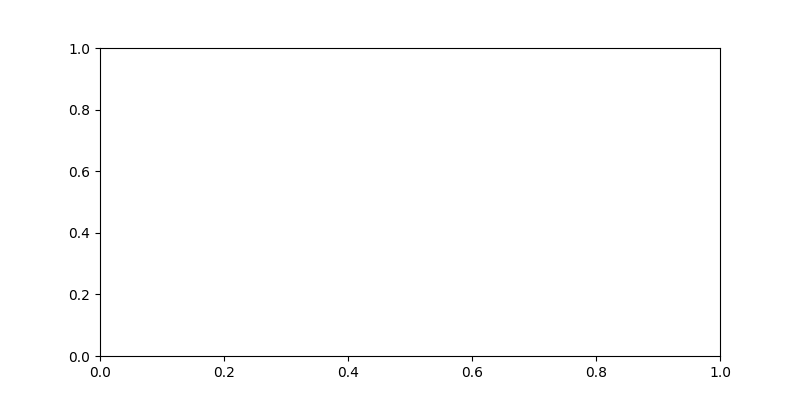

In [21]:
fig_name = 'max_test_stat'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(8, 4))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex=True, sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0})

ax = axes[0, 0]  # ----------------- new panel

sources = np.where(reliability > 0)
sc = ax.scatter(test_stat[sources], max_test_stat[sources]/test_stat[sources],
                marker='o', s=10, c=reliability[sources], cmap='nipy_spectral_r')

ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
top = np.where(parent == np.arange(parent.size))[0]
top

In [ ]:
def print_children(node, level, max_level=6, max_children=2):
    children = np.where(parent == node)[0]
    print(f'{level*"|"}--{node} : A={area[node]}, T={test_stat[node]:.2g}({max_test_stat[node]:.2g}) R={reliability[node]:.2g}, {children.size} children')# ({children[:max_children]})')
    decreasing_area = np.argsort(area[children])[::-1]
    if level < max_level:
        for child in children[decreasing_area][:max_children]:
            if child != node: #and reliability[child] > 0:
                print_children(child, level+1, max_level, max_children)

print_children(top[1], 0)


## Reliability

In [ ]:
importlib.reload(scripts.reliability)
reliability = scripts.reliability.run(max_test_stat, area, plots=True)

In [ ]:
importlib.reload(scripts.reliability)
reliability = scripts.reliability.run(test_stat, area, plots=True)

In [ ]:
true_overdensity = reliability > 0.43
n_sources = np.count_nonzero(true_overdensity)
print(f'{n_sources} potential sources found')

## Clean-up

In [ ]:
fig_name = 'explore_significance'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(8, 8))

axes = fig.subplots(nrows=2, ncols=2, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0})
fig.suptitle(object_name)


def plot_projection(data, projection_axis, ax, transpose=False):
    intensity = np.cbrt(np.nanmean(data**3, axis=projection_axis))
    #intensity = np.nanmean(data, axis=projection_axis)
    if transpose:
        intensity = intensity.T
    print(intensity.shape)
    pmin, p50, pmax = np.nanpercentile(intensity, [1, 50, 99.9])
    intensity_scale = colors.SymLogNorm(vmin=pmin, linthresh=2*p50-pmin, vmax=pmax)
    im = ax.imshow(
        intensity,
        interpolation='nearest', origin='lower',
        cmap='rainbow',
        vmin=-pmax, vmax=pmax,
        #norm=intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)
    ax.set_aspect('auto')


plot_projection(mean_significance, 0, axes[1, 0])
plot_projection(mean_significance, 2, axes[1, 1], True)
plot_projection(mean_significance, 1, axes[0, 0])


for ax in axes.flatten():
    ax.tick_params(which='both', direction='in')
    ax.grid(alpha=.5)
fig.set_tight_layout(True)
plt.show()

In [ ]:
importlib.reload(scripts.cleanup)
label, old_label = scripts.cleanup.run(label, parent, area, true_overdensity, plots=True)

## Explore results

### Definitions

In [ ]:
plots = True
data_dimensionality = sorted_strides.size-1
#p0, p16, p50, p100 = np.nanpercentile(data, [0, 16, 50, 100])
#colour_scale = colors.SymLogNorm(vmin=p50-3*(p50-p16), linthresh= p50+3*(p50-p16), vmax=p100)
#data_min = data.ravel()[argsorted_data[0]]
#pivot = np.percentile(data[data > 0], 1)
#scale_min = data.ravel()[argsorted_data[int(argsorted_data.size*.01)]]
#pivot = data.ravel()[argsorted_data[int(argsorted_data.size*.5)]]  # median
#scale_max = data.ravel()[argsorted_data[int(argsorted_data.size*.99)]]
#scale_max = data.ravel()[argsorted_data[-1]]
#colour_scale = colors.SymLogNorm(vmin=scale_min, linthresh=2*pivot-scale_min, vmax=scale_max)
p0, p16, p50, p100 = np.nanpercentile(data, [0, 16, 50, 100])
colour_scale = colors.SymLogNorm(vmin=p16, linthresh=2*p50-p16, vmax=p100+p16)

#colour_scale = colors.LogNorm(vmin=p16, vmax=p100)

In [ ]:
n_sources = np.unique(label).size
my_cmap = np.vstack([(np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, np.ones(n_sources)]).T
my_cmap[0, :] = [0., 0., 0., 1.]
final_cmap = colors.ListedColormap(my_cmap)

### Segmentation

In [ ]:
def show_parents(labels, parents, ax):
    for obj in np.unique(labels):
        if area[obj] > 10:
            y_obj, x_obj = np.unravel_index(np.nanargmax(np.where(label == obj, data, -np.inf)), data.shape)
            y_par, x_par = np.unravel_index(np.nanargmax(np.where(label == parents[obj], data, -np.inf)), data.shape)
            #print(f'{obj}, {parents[obj]}, {x_obj, y_obj}')
            ax.plot([x_obj, x_par], [y_obj, y_par], 'k+-', alpha=.5)

def show_segmentation(intensity, labels, intensity_scale):
    fig_name = 'segmentation'
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=(12, 4))
    
    axes = fig.subplots(nrows=1, ncols=3, squeeze=False,
                        sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

    ax = axes[0, 0]
    ax.set_title(object_name)
    im = ax.imshow(
        intensity,
        interpolation='nearest', origin='lower',
        #cmap='ocean',
        #cmap='nipy_spectral',
        #cmap='terrain',
        #cmap='magma',
        #cmap='gist_heat',
        cmap='gist_earth',
        #cmap='YlGn',
        norm=intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)

    ax = axes[0, 1]
    ax.set_title(f'segmentation ({n_sources} objects)')
    im = ax.imshow(
        #labels == study_object,
        labels,
        interpolation='nearest', origin='lower',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)
    #show_parents(labels, parent, ax)

    '''
    ax = axes[0, 1]
    ax.set_title(object_name)
    im = ax.imshow(
        total_weight,
        interpolation='nearest', origin='lower',
        #cmap='ocean',
        #cmap='nipy_spectral',
        cmap='terrain',
        norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)
    '''

    '''
    ax = axes[0, 2]
    ax.set_title(f'segmentation ({n_sources} objects)')
    im = ax.imshow(
        new_label,
        interpolation='nearest', origin='lower',
        cmap=final_cmap,
        )
    cb = fig.colorbar(im, ax=ax)
    '''

    '''
    ax = axes[0, 2]
    ax.set_title(f'Reliability')
    im = ax.imshow(
        reliability[old_label[labels]],
        interpolation='nearest', origin='lower',
        #cmap='nipy_spectral_r',
        #cmap='inferno_r',
        cmap='hot_r',
        #cmap='gist_heat',
        )
    cb = fig.colorbar(im, ax=ax)
    '''

    ax = axes[0, 2]
    ax.set_title(f'Test statistic')
    im = ax.imshow(
        test_stat[labels]*area[labels],
        interpolation='nearest', origin='lower',
        #cmap='nipy_spectral_r',
        #cmap='inferno_r',
        cmap='hot_r',
        norm=colors.LogNorm(vmin=1e-7, vmax=1e-3),
        )
    cb = fig.colorbar(im, ax=ax)

    for ax in axes.flatten():
        ax.tick_params(which='both', direction='in')
        ax.grid(alpha=.5)
    fig.set_tight_layout(True)
    plt.show()

In [ ]:
if plots and data_dimensionality == 2:
    show_segmentation(data, label, colour_scale)

elif plots and data_dimensionality == 3:
    axis = 0
    intensity = np.nanmean(mean_significance, axis=axis)
    #intensity = np.nanmean(data**2, axis=1)
    #intensity = np.nanmax(data, axis=1)
    #intensity = np.cbrt(np.nanmean((mean_significance-np.nanmean(mean_significance))**3, axis=axis))
    pmin, p50, pmax = np.nanpercentile(intensity, [16, 50, 99])
    intensity_scale = colors.SymLogNorm(vmin=pmin, linthresh=2*p50-pmin, vmax=pmax)
    #intensity_scale = colors.Normalize(vmin=0, vmax=1)
    show_segmentation(intensity, np.nanmax(label, axis=axis), intensity_scale)


In [ ]:
'''
'''
if plots and data_dimensionality == 3:

    mode = 0
    projection_axis = 0
    max_map = np.nanmax(label, axis=projection_axis)

    #boundary = np.zeros_like(max_map)
    #boundary[:, :-1][max_map[:, :-1] != max_map[:, 1:]] = 1
    #boundary[:-1, :][max_map[:-1, :] != max_map[1:, :]] = 1
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(8, 8))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'bottom': .01, 'left': .1, 'top': .99, 'right': .92,
                                   'hspace': .01, 'wspace': .1},
                      subplot_kw={'projection': wcs},
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    #fig.set_tight_layout(True)

    '''
    ax[0, 0].set_title('Input data (max)')
    im = ax[0, 0].imshow(
        np.nanmax(data, axis=0),
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colour_scale
    )
    '''
    ax[0, 0].set_title('Mean significance')
    im = ax[0, 0].imshow(
        np.nanmean(mean_significance, axis=projection_axis),
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colour_scale
        #norm = intensity_scale
    )
    #ax[0, 0].contour(boundary, levels=[.5], colors='k', linewidths=0.1)
    #ax[1, 0].contour(boundary, levels=[.5], colors='k', linewidths=0.1)
    #ax[1, 1].contour(boundary, levels=[.5], colors='k', linewidths=0.1)
    #ax[0, 0].contour(max_map, levels=np.arange(n_sources)+.5, colors='k', linewidths=0.1)
    #ax[1, 0].contour(max_map, levels=np.arange(n_sources)+.5, colors='k', linewidths=0.1)
    #ax[1, 1].contour(max_map, levels=np.arange(n_sources)+.5, colors='w', linewidths=0.1)
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(0, c='k', ls=':')
    #cb.ax.axhline(data.threshold-mode, c='k', ls='--')
    
    ax[0, 1].set_title('Input data (rms)')
    im = ax[0, 1].imshow(
        #(np.sqrt(np.nanmean((data-mode)**2, axis=0)) + np.nanmax(data, axis=0))/2,
        np.nansum(data, axis=projection_axis)/np.sqrt(np.nanmean(data**2, axis=projection_axis)),
        vmin=0,
        interpolation='nearest', origin='lower', cmap='terrain',
        #norm = colors.SymLogNorm(vmin=-delta_th, linthresh=3*delta_th, vmax=np.max(data-mode)),
        #vmin=-delta/100, vmax=3*delta/10,
        #norm = colour_scale,
    )
    #ax[0, 1].contour(max_map, levels=[0.5])
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(0, c='k', ls=':')
    #cb.ax.axhline(data.threshold-mode, c='k', ls='--')
    
    ax[1, 0].set_title(f'Final selection map (max)\n({n_sources} objects)')
    im = ax[1, 0].imshow(
        max_map,
        interpolation='nearest', origin='lower',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    #ax[1, 1].set_title('<lbl^2> / <lbl>')
    im = ax[1, 1].imshow(
        reliability[old_label[max_map]],
        #np.nansum(final_labels**2, axis=0) / np.nansum(final_labels, axis=0),
        interpolation='nearest', origin='lower',
        cmap='nipy_spectral_r',
        #vmin=n_reliable/(n_sources+1), vmax=reliability_threshold,
        #cmap='rainbow_r',
        #vmin=1, vmax=n_final_labels-1,
        )
    cb = fig.colorbar(im, ax=ax[1, 1])


In [ ]:
if plots and data_dimensionality == 3:
    x_range = np.round(plt.figure('segmentation').get_axes()[0].get_xlim()).astype(int)
    y_range = np.round(plt.figure('segmentation').get_axes()[0].get_ylim()).astype(int)
    section = (data[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]-mode)
    section_lables = label[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    norm = (y_range[1] - y_range[0]) * (x_range[1] - x_range[0])
    section_labels = label[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    unique_section_labels = np.unique(section_labels)

    vertical_slit = np.max(section_labels, axis=2).T
    horizontal_slit = np.max(section_labels, axis=1).T

    plt.close('spectrum')
    fig = plt.figure('spectrum', figsize=(8, 8))
    ax = fig.subplots(nrows=5, ncols=1, squeeze=False,
                      sharex=True, sharey=False,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        
    fig.set_tight_layout(True)

    
    ax[0, 0].set_title(f'Mean spectra for x in {x_range}, y in {y_range}\n({unique_section_labels.size} objects)')
    im = ax[0, 0].imshow(
        vertical_slit,
        interpolation='nearest', origin='lower',
        #vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    ax[0, 0].set_aspect('auto')
    ax[0, 0].set_ylabel(r'$\Delta y$')


    im = ax[1, 0].imshow(np.nanmean(section, axis=2).T,
                         interpolation='nearest', origin='lower', cmap='terrain',
                         #norm=colour_scale,
                        )
    #ax[1, 0].contour(vertical_slit, levels=0)
    ax[1, 0].set_aspect('auto')
    ax[1, 0].set_ylabel(r'$\Delta y$')


    ax[2, 0].plot(np.nanmean(section, axis=(1, 2)), 'k-', lw=3, alpha=.25)
    ax[2, 0].set_ylabel('spectrum')
    '''
    '''
    for lbl in unique_section_labels[:10]:  # Dirty fix
        mask = np.zeros_like(section)
        mask[section_labels == lbl] = 1
        if lbl == 0:
            ls = ':'
        else:
            ls = '-'
        ax[2, 0].plot(np.nansum(section*mask, axis=(1, 2))/norm, alpha=.5, ls=ls, label=f'{lbl}')
    mean_error = 1/np.sqrt(section.shape[1]*section.shape[2])
    #ax[2, 0].axhline(delta_th*mean_error*bg_std, c='k', ls=':')
    #ax[2, 0].axhline(-delta_th*mean_error*bg_std, c='k', ls=':')
    ax[2, 0].legend()
    
    
    im = ax[3, 0].imshow(np.nanmean(section, axis=1).T,
        #(np.nanmax(section, axis=1) + np.sqrt(np.nanmean(section**2, axis=1))).T/2,
                         interpolation='nearest', origin='lower', cmap='terrain',
                         #vmin=0,
                         norm=colour_scale,
                        )
    #ax[3, 0].contour(horizontal_slit, levels=0)
    ax[3, 0].set_aspect('auto')
    ax[3, 0].set_ylabel(r'$\Delta x$')

    ax[4, 0].set_ylabel(r'$\Delta x$')
    im = ax[4, 0].imshow(
        horizontal_slit,
        interpolation='nearest', origin='lower',
        #vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    ax[4, 0].set_aspect('auto')
    ax[4, 0].set_ylabel(r'$\Delta x$')

    ax[-1, 0].set_xlabel('frequency / wavelength channel')


## Save FITS file

In [ ]:
hdu_out = fits.PrimaryHDU(final_labels)
hdu_out.writeto('output/HOT_labels.fits', overwrite=True)
'''
'''


In [ ]:
if data_dimensionality == 3:
    hdu_out = fits.PrimaryHDU(np.sum(final_labels, axis=0) / (np.count_nonzero(final_labels, axis=0) + 1e-30))
    hdu_out.writeto('output/HOT_mask.fits', overwrite=True)
'''
'''
